[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4902
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 200
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 12.023362
Fold 1 RMSLE: 0.1339
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4898
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 201
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start tra

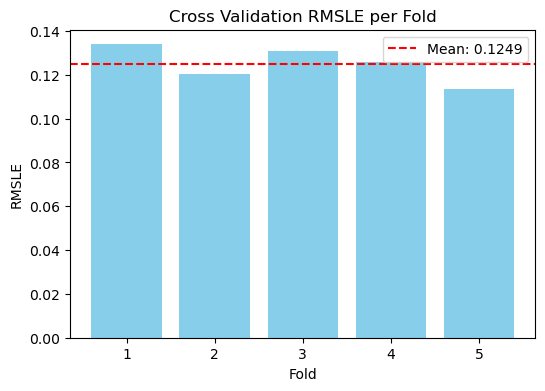


Average Ensemble RMSLE: 0.1152


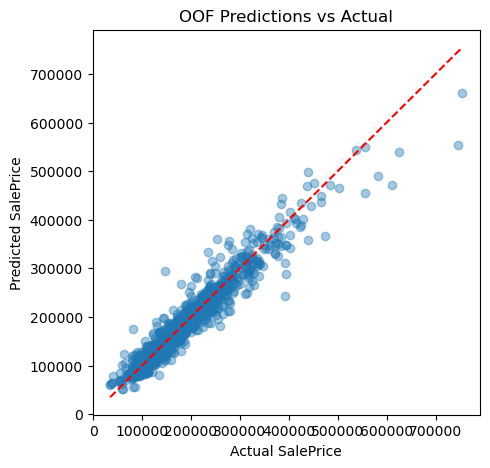

Saved submission file: submission_ensemble.csv ✅


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# ===============================
# 前処理関数
# ===============================
def fill_missing_values(df):
    garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
    for col in garage_cols:
        df[col] = df[col].fillna('None')
    garage_num_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars']
    for col in garage_num_cols:
        df[col] = df[col].fillna(0)

    bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    for col in bsmt_cols:
        df[col] = df[col].fillna('None')
    bsmt_num_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                     'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
    for col in bsmt_num_cols:
        df[col] = df[col].fillna(0)

    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
    for col in ['MSZoning','Functional','KitchenQual','Exterior1st',
                'Exterior2nd','SaleType','Utilities']:
        df[col] = df[col].fillna(df[col].mode()[0])

    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    for col in df.select_dtypes(include=np.number).columns:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].median())
    return df

def create_features(df):
    df['TotalSF'] = df['GrLivArea'] + df['TotalBsmtSF']
    df['TotalHouseArea'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['GrLivArea'] + df['TotalBsmtSF']
    df['OverallQual_x_GrLivArea'] = df['OverallQual'] * df['GrLivArea']
    df['OverallQual_x_TotalBsmtSF'] = df['OverallQual'] * df['TotalBsmtSF']
    df['OverallQual_x_TotalSF'] = df['OverallQual'] * df['TotalSF']
    df['OverallQual_x_YearBuilt'] = df['OverallQual'] * df['YearBuilt']
    df['OverallQual_x_YearRemodAdd'] = df['OverallQual'] * df['YearRemodAdd']
    return df

def preprocess_onehot(train, test, target_col="SalePrice", drop_id=True):
    X_train = train.drop([target_col], axis=1)
    y = train[target_col]
    if drop_id and "Id" in X_train.columns:
        X_train = X_train.drop("Id", axis=1)
    if drop_id and "Id" in test.columns:
        test = test.drop("Id", axis=1)

    combined = pd.concat([X_train, test], axis=0).reset_index(drop=True)
    combined = pd.get_dummies(combined, dummy_na=True)
    X_train, X_test = combined.iloc[:len(train), :], combined.iloc[len(train):, :]
    X_train, X_test = X_train.align(X_test, join="left", axis=1)
    X_test = X_test.fillna(0)
    return X_train, y, X_test

# ===============================
# 評価関数
# ===============================
def rmsle(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# ===============================
# Foldごとのスコア棒グラフ
# ===============================

def plot_cv_scores(cv_scores):
    plt.figure(figsize=(6,4))
    plt.bar(range(1, len(cv_scores)+1), cv_scores, color="skyblue")
    plt.axhline(np.mean(cv_scores), color="red", linestyle="--", label=f"Mean: {np.mean(cv_scores):.4f}")
    plt.title("Cross Validation RMSLE per Fold")
    plt.xlabel("Fold")
    plt.ylabel("RMSLE")
    plt.legend()
    plt.show()

# ===============================
# LGBM 学習
# ===============================
def run_lgbm_cv(X, y, n_splits=5, random_state=42):
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_preds = np.zeros(len(X))
    cv_scores = []
    final_model = None

    for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        y_tr_log, y_val_log = np.log1p(y_tr), np.log1p(y_val)

        model = lgb.LGBMRegressor(
            objective="regression",
            learning_rate=0.05,
            num_leaves=31,
            n_estimators=10000,
            random_state=random_state
        )
        model.fit(X_tr, y_tr_log,
                  eval_set=[(X_val, y_val_log)],
                  eval_metric="rmse",
                  callbacks=[lgb.early_stopping(50, verbose=False)])

        val_preds_log = model.predict(X_val, num_iteration=model.best_iteration_)
        val_preds = np.expm1(val_preds_log)
        oof_preds[val_idx] = val_preds

        score = rmsle(y_val, val_preds)
        cv_scores.append(score)
        print(f"Fold {fold+1} RMSLE: {score:.4f}")
        final_model = model

    cv_rmsle = np.mean(cv_scores)
    print(f"\nAverage CV RMSLE: {cv_rmsle:.4f}")
    plot_cv_scores(cv_scores)
    return cv_rmsle, oof_preds, final_model


# ===============================
# Ridge / Lasso 学習
# ===============================
def run_linear_models(X, y_log):
    folds = KFold(n_splits=5, shuffle=True, random_state=42)
    ridge_oof, lasso_oof = np.zeros(len(X)), np.zeros(len(X))
    
    for train_idx, val_idx in folds.split(X, y_log):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y_log.iloc[train_idx], y_log.iloc[val_idx]

        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)        
        X_val_scaled = scaler.transform(X_val)
        ridge = Ridge(alpha=1.0, random_state=42)
        ridge.fit(X_tr_scaled, y_tr)
        ridge_oof[val_idx] = np.expm1(ridge.predict(X_val_scaled))
        lasso = Lasso(alpha=0.0005, max_iter=20000, random_state=42)
        lasso.fit(X_tr_scaled, y_tr)
        lasso_oof[val_idx] = np.expm1(lasso.predict(X_val_scaled))

    return ridge_oof, lasso_oof

# ===============================
# 予測値 vs 実測値の散布図
# ===============================
def plot_pred_vs_actual(y_true, y_pred, title="OOF Predictions vs Actual"):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.4)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual SalePrice")
    plt.ylabel("Predicted SalePrice")
    plt.title(title)
    plt.show()

# ===============================
# 全体実行
# ===============================
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train = fill_missing_values(train.copy())
test = fill_missing_values(test.copy())
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)
train = create_features(train)
test = create_features(test)
X_train, y_train, X_test = preprocess_onehot(train, test)
y_train_log = np.log1p(y_train)

ridge_oof, lasso_oof = run_linear_models(X_train, y_train_log)
lgbm_cv_rmsle, lgbm_oof, lgbm_model = run_lgbm_cv(X_train, y_train)
ensemble_oof = (lgbm_oof * 0.5 + ridge_oof * 0.25 + lasso_oof * 0.25)
print(f"\nAverage Ensemble RMSLE: {rmsle(y_train, ensemble_oof):.4f}")
plot_pred_vs_actual(y_train, ensemble_oof)

# ===============================
# 提出用
# ===============================

lgbm_preds = np.expm1(lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration_))
ridge_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0, random_state=42))
]).fit(X_train, y_train_log)

lasso_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=0.0005, max_iter=20000, random_state=42))
]).fit(X_train, y_train_log)

ridge_preds = np.expm1(ridge_model.predict(X_test))
lasso_preds = np.expm1(lasso_model.predict(X_test))

# --- 提出アンサンブル ---
final_preds = (lgbm_preds * 0.5 + ridge_preds * 0.25 + lasso_preds * 0.25)
submission = pd.DataFrame({"Id": test["Id"], "SalePrice": final_preds})
submission.to_csv("submission_ensemble.csv", index=False)
print("Saved submission file: submission_ensemble.csv")

